In [57]:
from random import choice

import lightning as L
import torch
from torch import optim, nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torchvision.transforms import v2
from torchmetrics import functional as mF
import matplotlib.pyplot as plt

### Define the baseline

Simple MLP with 64 hidden dimensions.

In [2]:
class MNISTDataset(MNIST):
    pass

class DigitDataModule(L.LightningDataModule):
    # TAKEN FROM https://github.com/sxg/PyTorch-Lightning-MNIST-Classifier/blob/main/DigitDataModule.py
    def __init__(self, dataset, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = dataset
        self.transform = v2.Compose([
          v2.ToTensor(),
          v2.Normalize((0.5,), (0.5,))
        ])

    def prepare_data(self):
        self.dataset("MNIST", train=True, download=True)
        self.dataset("MNIST", train=False, download=True)

    def setup(self, stage):
        if stage == "fit":
            full_set = self.dataset(root="MNIST", train=True, transform=self.transform)
            train_set_size = int(len(full_set) * 0.8)
            val_set_size = len(full_set) - train_set_size
            seed = torch.Generator().manual_seed(42)
            self.train_set, self.val_set = data.random_split(full_set, [train_set_size, val_set_size], generator=seed)
        elif stage == "test":
            self.test_set = self.dataset(root="MNIST", train=False, transform=self.transform)

    def train_dataloader(self):
        return data.DataLoader(self.train_set, batch_size=self.batch_size, num_workers=16)

    def val_dataloader(self):
        return data.DataLoader(self.val_set, batch_size=self.batch_size, num_workers=16)

    def test_dataloader(self):
        return data.DataLoader(self.test_set, batch_size=self.batch_size, num_workers=16)

class DigitModuleBaseline(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU())

        self.classifier = nn.Linear(64, 10)

    def data_step(self, batch, log_name):
        x, y = batch
        
        latent = self.mlp(x.view(-1, 784))
        pred = self.classifier(latent)

        loss = F.cross_entropy(pred, y)
        self.log(f"{log_name}/loss", loss, prog_bar=True)

        acc = mF.accuracy(pred, y, task="multiclass", num_classes=10)
        self.log(f"{log_name}/accuracy", acc, prog_bar=True)

        return pred, loss, acc

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        pred, loss, _ = self.data_step(batch, "train")
        return loss

    def validation_step(self, batch, batch_idx):
        pred, loss, _ = self.data_step(batch, "valid")
        return loss

    def test_step(self, batch, batch_idx):
        pred, loss, acc = self.data_step(batch, "test")
        return {"loss": loss, "acc": acc}

Train the baseline

In [6]:
dm = DigitDataModule(MNISTDataset, batch_size=64)

model = DigitModuleBaseline()
trainer = L.Trainer(
  #devices=[0], 
  accelerator="cpu",
  max_epochs=5)

#trainer.fit(model, datamodule=dm)
#trainer.test(model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Let's sandra it

In [24]:
import sys
sys.path.append("../../")

import rdflib
from sandra.ontology import KnowledgeBase
from sandra.torch import ReasonerModule

dc = KnowledgeBase.from_graph(rdflib.Graph().parse("digital_display.ttl"))
reasoner = ReasonerModule(dc, t=0.1)

Define the new model with the projection

In [69]:
class SandraDigitModule(DigitModuleBaseline):
    def __init__(self, reasoner):
        super().__init__()
        self.reasoner = reasoner
        sandra_dim = len(self.reasoner._encoded_attrs)
        
        self.mlp = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU()
        )

        self.proj = nn.Sequential(
            nn.Linear(64, sandra_dim), 
            nn.Tanh())

        self.classifier = nn.Linear(64 + len(self.reasoner.kb.frames), 10)
        
    def data_step(self, batch, log_name):
        x, y = batch

        x = x.view(-1, 784)
        z = self.mlp(x)
        proj = self.proj(z)
        
        inf = self.reasoner(proj)
        y_inf = self.reasoner(self.reasoner._frame_gate[y])
        inference_loss = F.mse_loss(inf, y_inf)
        self.log(f"{log_name}/inference_loss", inference_loss, prog_bar=True)

        pred = self.classifier(torch.cat([z, inf], dim=-1))
        classification_loss = F.cross_entropy(pred, y)
        self.log(f"{log_name}/classification_loss", classification_loss, prog_bar=True)

        acc = mF.accuracy(pred, y, task="multiclass", num_classes=10)
        self.log(f"{log_name}/accuracy", acc, prog_bar=True)
        
        loss = classification_loss + inference_loss
        
        return pred, loss, acc

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [55]:
model = SandraDigitModule(reasoner)
trainer = L.Trainer(
  #devices=[0], 
  #accelerator="gpu",
  max_epochs=5)

trainer.fit(model, datamodule=dm)
trainer.test(model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | mlp        | Sequential     | 50.2 K | train
1 | classifier | Linear         | 720    | train
2 | reasoner   | ReasonerModule | 0      | eval 
3 | proj       | Linear         | 455    | train
------------------------------------------------------
51.4 K    Trainable params
0         Non-trainable params
51.4 K    Total params
0.206     Total estimated model params size (MB)
5         Modules in train mode
1         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/n28div/miniconda3/envs/sandra/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: 100%|██████████| 750/750 [00:06<00:00, 120.79it/s, v_num=225, train/inference_loss=0.0306, train/classification_loss=0.139, train/accuracy=0.953, valid/inference_loss=0.0308, valid/classification_loss=0.169, valid/accuracy=0.951] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 264.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.9562000036239624     │
│ test/classification_loss  │    0.14902405440807343    │
│    test/inference_loss    │   0.028598645702004433    │
└───────────────────────────┴───────────────────────────┘

[{'test/inference_loss': 0.028598645702004433,
  'test/classification_loss': 0.14902405440807343,
  'test/accuracy': 0.9562000036239624}]

Target tensor(1)
Inferred situation: 
	 Attribute(name='https://w3id.org/geometryofmeaning/sandra/digital-display#SegmentAOn')
	 Attribute(name='https://w3id.org/geometryofmeaning/sandra/digital-display#SegmentBOn')
	 Attribute(name='https://w3id.org/geometryofmeaning/sandra/digital-display#SegmentCOn')
	 Attribute(name='https://w3id.org/geometryofmeaning/sandra/digital-display#SegmentDOn')


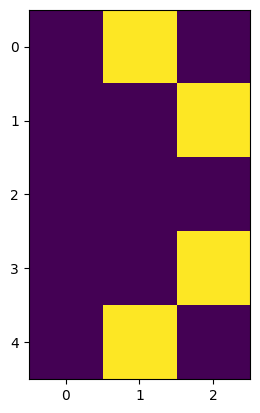

In [56]:
IDX = 6
image, label = next(iter(dm.train_dataloader()))

z = model.mlp(image[IDX].reshape(1, -1))
proj = model.proj(z)

inf = reasoner(proj)
#pred = model.classifier(torch.cat([latent, inf], dim=-1))
#pred = model.classifier(latent)

#print("Pred", pred.argmax())
print("Target", label[IDX])

inferred_situation = [dc.attributes[i] for i in torch.where((proj @ reasoner._encoded_attrs) > 0)[1].tolist()]
print("Inferred situation: \n\t", "\n\t ".join([str(e) for e in inferred_situation]))

seven_seg = [1 if r in inferred_situation else 0 for r in dc.attributes]
seven_seg = [0, seven_seg[0], 0, 
             seven_seg[5], 0, seven_seg[1],
             0, seven_seg[-1], 0,
             seven_seg[4], 0, seven_seg[2],
             0, seven_seg[3], 0 ]
plt.imshow(torch.tensor(seven_seg).reshape(5, 3))
plt.show()

Rotated MNIST

In [58]:
class RotatedDigitDataModule(DigitDataModule):
    # TAKEN FROM https://github.com/sxg/PyTorch-Lightning-MNIST-Classifier/blob/main/DigitDataModule.py
    def __init__(self, dataset, train_rotations, test_rotations, batch_size=64):
        super().__init__(dataset, batch_size=batch_size)
        base_transforms = [
          v2.ToTensor(),
          v2.Normalize((0.5,), (0.5,))
        ]

        self.train_transform = v2.Compose(
            base_transforms + [ v2.Lambda(lambda i: v2.functional.rotate(i, choice(train_rotations))), ]
        )

        self.test_transform = v2.Compose(
            base_transforms + [ v2.Lambda(lambda i: v2.functional.rotate(i, choice(test_rotations))), ]
        )


    def setup(self, stage):
        if stage == "fit":
            full_set = self.dataset(root="MNIST", train=True, transform=self.train_transform)
            train_set_size = int(len(full_set) * 0.8)
            val_set_size = len(full_set) - train_set_size
            seed = torch.Generator().manual_seed(42)
            self.train_set, self.val_set = data.random_split(full_set, [train_set_size, val_set_size], generator=seed)
        elif stage == "test":
            self.test_set = self.dataset(root="MNIST", train=False, transform=self.test_transform)

In [71]:
#dm = RotatedDigitDataModule(MNISTDataset, (30, 45), (0, 90), batch_size=64)
dm = RotatedDigitDataModule(MNISTDataset, (30, 45, 60), (0, 90), batch_size=64)

model = DigitModuleBaseline()
trainer = L.Trainer(
  #devices=[0], 
  accelerator="cpu",
  max_epochs=5)

trainer.fit(model, datamodule=dm)
trainer.test(model, datamodule=dm)

/home/n28div/miniconda3/envs/sandra/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | mlp        | Sequential | 50.2 K | train
1 | classifier | Linear     | 650    | train
--------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 750/750 [00:05<00:00, 127.27it/s, v_num=232, train/loss=0.131, train/accuracy=0.969, valid/loss=0.201, valid/accuracy=0.941] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 283.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.5424000024795532     │
│         test/loss         │    1.7742990255355835     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 1.7742990255355835, 'test/accuracy': 0.5424000024795532}]

In [72]:
model = SandraDigitModule(reasoner)
trainer = L.Trainer(
  #devices=[0], 
  #accelerator="gpu",
  max_epochs=5)

trainer.fit(model, datamodule=dm)
trainer.test(model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | mlp        | Sequential     | 50.2 K | train
1 | classifier | Linear         | 750    | train
2 | reasoner   | ReasonerModule | 0      | eval 
3 | proj       | Sequential     | 455    | train
------------------------------------------------------
51.4 K    Trainable params
0         Non-trainable params
51.4 K    Total params
0.206     Total estimated model params size (MB)
7         Modules in train mode
1         Modules in eval mode


Epoch 4: 100%|██████████| 750/750 [00:07<00:00, 105.52it/s, v_num=233, train/inference_loss=0.0209, train/classification_loss=0.151, train/accuracy=0.953, valid/inference_loss=0.0258, valid/classification_loss=0.191, valid/accuracy=0.944] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 248.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.5396000146865845     │
│ test/classification_loss  │     1.810421347618103     │
│    test/inference_loss    │    0.06789376586675644    │
└───────────────────────────┴───────────────────────────┘

[{'test/inference_loss': 0.06789376586675644,
  'test/classification_loss': 1.810421347618103,
  'test/accuracy': 0.5396000146865845}]